# Airfoil Lift Coefficient Prediction
Airfoil Lift Coefficient Prediction using Multi-layer CNNs


## Contents
* Loading Dataset
* Preparing and Cleaning Data
* Preprocessing Data
* Creating Model
* Evaluating Model

In [42]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from openpyxl import load_workbook
from sklearn.preprocessing import StandardScaler
from PIL import Image as PILImage
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
import openpyxl
from openpyxl_image_loader import SheetImageLoader
import io
import seaborn as sns
from openpyxl.drawing.image import Image
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import concatenate, Input, Conv2D, MaxPooling2D, Activation, Dense, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization

**Reading textual data** (unnecessary columns has been removed)

In [43]:
data = pd.read_excel('final edition.xlsx').drop(['AIRFOIL'], axis=1).iloc[:, :-1]

In [44]:
data.head()

,RYNOLDS,ALPHA,CL,CD
0,40400.0,-1.20,0.12,0.0257
1,40400.0,0.88,0.329,0.0213
2,40400.0,2.77,0.543,0.0371
3,40400.0,5.00,0.839,0.0438
4,40400.0,6.98,1.002,0.0346


In [4]:
data.shape

(13138, 4)

No missing values here

In [5]:
data.isna().sum()

RYNOLDS    0
ALPHA      0
CL         0
CD         0
dtype: int64

**Reading Visual data**

In [6]:
pxl_doc = openpyxl.load_workbook('final edition.xlsx')

In [7]:
sheet = pxl_doc['V1']

In [8]:
image_loader = SheetImageLoader(sheet)

A list to store images

In [9]:
images = []

A list to store missing images if there exists any

In [10]:
missing_cells = []

In [11]:
# Iterating all cells
for i in range(2, 13140):
    cell = 'F' + str(i)
    try:
        image = image_loader.get(cell)
        # Preprocessing image (resizing and reducing dimension)
        image = image.convert('RGB').resize((64, 64))
        images.append(image)
    except ValueError as e:
        # if an error raises, the image does not exist
        e = str(e)
        start_index = e.find('F')
        end_index = e.find(' ', start_index)
        missing_cells.append(e[start_index: end_index])
        continue

In [12]:
len(images)

12304

In [13]:
len(missing_cells)

834

There are 834 missing images in the dataset that need to be removed

Now we need to remove those missing records from the textual data

In [14]:
for cell_name in missing_cells:
    col, row = cell_name[0], int(cell_name[1:]) - 1
    data.drop(index=row, inplace=True)

Take a look at both datasets

In [15]:
data.shape

(12304, 4)

In [16]:
len(images)

12304

In [17]:
type(images)

list

In [18]:
images = np.array(images)

In [19]:
images.shape

(12304, 64, 64, 3)

For sample one we have:

In [20]:
data.iloc[0]

RYNOLDS    40400.0
ALPHA         -1.2
CL            0.12
CD          0.0257
Name: 0, dtype: object

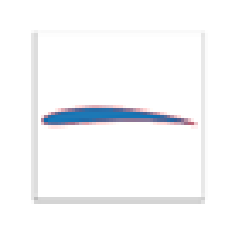

In [21]:
plt.imshow(images[0])
plt.axis('off')
plt.show()

## Preprocessing Data

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12304 entries, 0 to 13137
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   RYNOLDS  12304 non-null  float64
 1   ALPHA    12304 non-null  float64
 2   CL       12304 non-null  object 
 3   CD       12304 non-null  object 
dtypes: float64(2), object(2)
memory usage: 480.6+ KB


Convert to float

In [46]:
data['CL'] = pd.to_numeric(data['CL'], errors='coerce')
data['CD'] = pd.to_numeric(data['CD'], errors='coerce')

This may create NaN values

In [47]:
data.isna().sum()

RYNOLDS     0
ALPHA       0
CL          1
CD         12
dtype: int64

Replacing with median

In [48]:
data['CD'].fillna(data['CD'].median(), inplace=True)
data['CL'].fillna(data['CL'].median(), inplace=True)

**Scaling**

In [26]:
images = images / 255.0

Splitting data

In [65]:
X_train, X_test, IX_train, IX_test = train_test_split(data, images, random_state=5)

There are 2 targets

In [66]:
y_train = X_train[['CL', 'CD']].values
y_test = X_test[['CL', 'CD']].values

Standardization

In [67]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train[['RYNOLDS', 'ALPHA']])
X_test = ss.transform(X_test[['RYNOLDS', 'ALPHA']])

In [68]:
print(IX_train.shape)
print(y_train.shape)

(9228, 64, 64, 3)
(9228, 2)


In [69]:
print(IX_test.shape)
print(y_test.shape)

(3076, 64, 64, 3)
(3076, 2)


In [70]:
train_first_output = y_train[:, 0].reshape((-1,1))
train_second_output = y_train[:, 1].reshape((-1,1))
test_first_output = y_test[:, 0].reshape((-1,1))
test_second_output = y_test[:, 1].reshape((-1,1))

---
## Modeling
Two input channels
* Textual data
* Visual data


Two output channels
* CD
* CL

In [142]:
# Channel One => CNN
input_shape = (64, 64, 3)
input1 = Input(shape=input_shape)
conv1 = Conv2D(16, (3, 3), padding='same', activation='relu')(input1)
batchnorm1 = BatchNormalization(axis=-1)(conv1)
maxpool1 = MaxPooling2D(pool_size=(2, 2))(batchnorm1)

conv2 = Conv2D(32, (3, 3), padding='same', activation='relu')(maxpool1)
batchnorm2 = BatchNormalization(axis=-1)(conv2)
maxpool2 = MaxPooling2D(pool_size=(2, 2))(batchnorm2)

conv3 = Conv2D(64, (3, 3), padding='same', activation='relu')(maxpool2)
batchnorm3 = BatchNormalization(axis=-1)(conv3)
maxpool3 = MaxPooling2D(pool_size=(2, 2))(batchnorm3)

flatten1 = Flatten()(maxpool3)
dense1 = Dense(64, activation='relu')(flatten1)
batchnorm4 = BatchNormalization(axis=-1)(dense1)
dropout1 = Dropout(0.5)(batchnorm4)
m1 = Model(input1, dropout1)

# Channel Two => Multi-Layer Perceptron
m2 = Sequential()
m2.add(Dense(8, activation='relu', input_dim=2))
m2.add(Dense(4, activation='relu'))

# Combination
combinedModel = concatenate([m2.output, m1.output])

# First side of the output
densefs1 = Dense(8, activation='relu')(combinedModel)
densefs2 = Dense(1, activation='linear')(densefs1)

# Second side of the output
densefss1 = Dense(32, activation='relu')(combinedModel)
densefss1 = Dense(16, activation='relu')(densefss1)
densefss2 = Dense(1, activation='linear')(densefss1)

# Final model
model = Model(inputs=[m2.input, m1.input], outputs=[densefs2, densefss2])

In [143]:
model.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_26 (Conv2D)             (None, 64, 64, 16)   448         ['input_9[0][0]']                
                                                                                                  
 batch_normalization_32 (BatchN  (None, 64, 64, 16)  64          ['conv2d_26[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 max_pooling2d_24 (MaxPooling2D  (None, 32, 32, 16)  0           ['batch_normalization_32[0

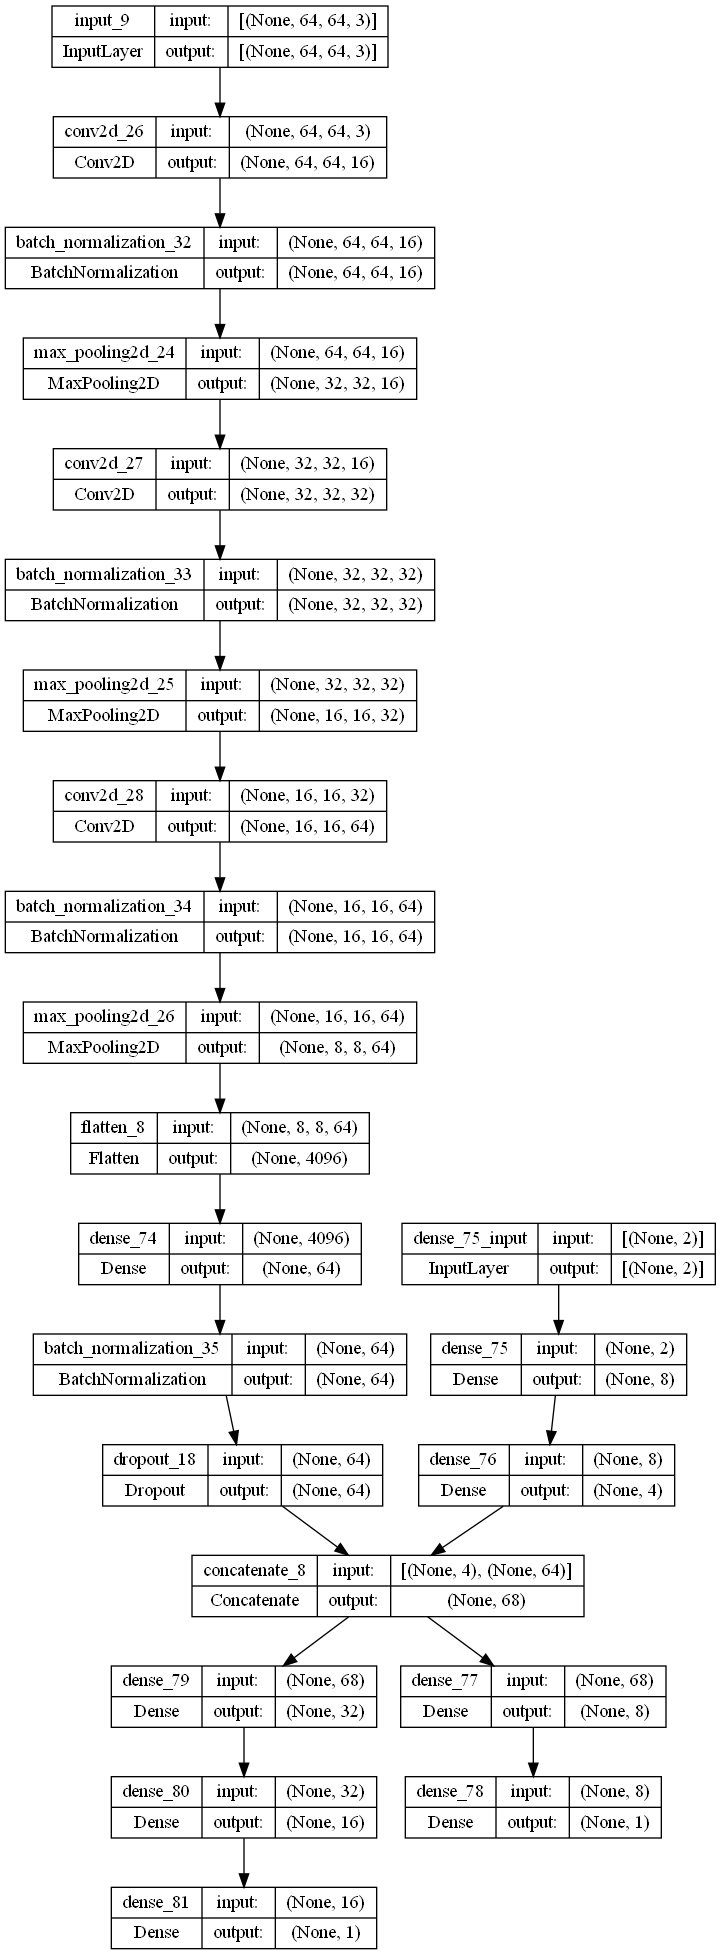

In [144]:
plot_model(model, show_shapes=True)

Compiling model

In [145]:
model.compile(optimizer=Adam(0.001), loss='mse')

In [146]:
history = model.fit([X_train, IX_train], [train_first_output, train_second_output], epochs=10, batch_size=64, 
                    validation_data=([X_test, IX_test], [test_first_output, test_second_output]))

Epoch 1/10
145/145 [==============================] - 39s 257ms/step - loss: 0.6240 - dense_78_loss: 0.5371 - dense_81_loss: 0.0869 - val_loss: 3.3864 - val_dense_78_loss: 2.5670 - val_dense_81_loss: 0.8194
Epoch 2/10
145/145 [==============================] - 39s 272ms/step - loss: 0.2603 - dense_78_loss: 0.2443 - dense_81_loss: 0.0160 - val_loss: 1.0006 - val_dense_78_loss: 0.9463 - val_dense_81_loss: 0.0543
Epoch 3/10
145/145 [==============================] - 39s 271ms/step - loss: 0.1416 - dense_78_loss: 0.1322 - dense_81_loss: 0.0094 - val_loss: 0.3905 - val_dense_78_loss: 0.3548 - val_dense_81_loss: 0.0357
Epoch 4/10
145/145 [==============================] - 39s 272ms/step - loss: 0.0919 - dense_78_loss: 0.0858 - dense_81_loss: 0.0060 - val_loss: 0.6503 - val_dense_78_loss: 0.6372 - val_dense_81_loss: 0.0131
Epoch 5/10
145/145 [==============================] - 39s 272ms/step - loss: 0.0637 - dense_78_loss: 0.0590 - dense_81_loss: 0.0048 - val_loss: 0.0444 - val_dense_78_loss: 

## Evaluation
### R2 Analysis

In [147]:
predicts = model.predict([X_test, IX_test])

97/97 [==============================] - 4s 40ms/step


In [148]:
r2_score(y_pred=predicts[0].flatten(), y_true=test_first_output.flatten())

0.940207876315137

For the first output (CL feature) we have reached 94% as r2 which is quite high and reliable

In [149]:
r2_score(y_pred=predicts[1].flatten(), y_true=test_second_output.flatten())

0.4564319869586505

For the second output we have reached 45%. It maay seem insufficient in comparison to the previous one but it is not and here is why.

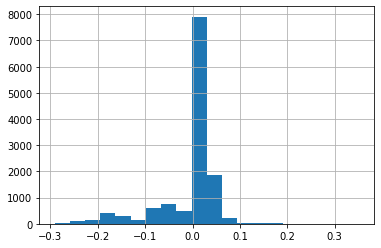

In [50]:
data['CD'].hist(bins=20)
plt.show()

For this column, values are centered around zero which makes r2 score an inapproperiate metric. **Why?**

R2 is sensitive when values are near zero and even one slight change results in high error. This makes the r2 score look not reliable but what is important to consider is that r2 is not a good metric for **CD** column.

### Total Loss Analysis

According to the chart below, total loss is quite low and it is converged to almost zero.

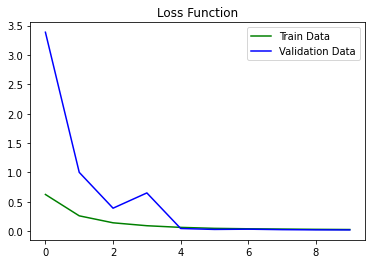

In [150]:
plt.plot(history.history['loss'], color='green', label='Train Data')
plt.plot(history.history['val_loss'], color='blue', label='Validation Data')
plt.title('Loss Function')
plt.legend()
plt.show()

### MSE Analysis

The chart below shows MSE for **CL** output which is quite low. This could be previously predicted due to its high r2 score.

As the trainig went on, the loss corresponding to both training and validation converged to almost zero.

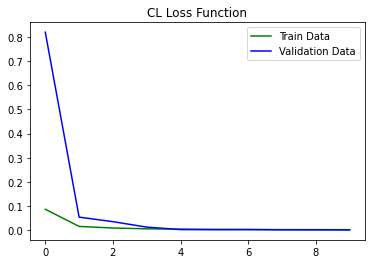

In [151]:
plt.plot(history.history['dense_81_loss'], color='green', label='Train Data')
plt.plot(history.history['val_dense_81_loss'], color='blue', label='Validation Data')
plt.title('CL Loss Function')
plt.legend()
plt.show()

At first, we saw that r2 score for **CD** was not as good as **CL** and the reason had something to do with its distribution. Here it is evident that MSE (loss) for **CL** converged to almost zero and its not insufficient.

So 45% r2 score is good for the second output and relatively relilable.

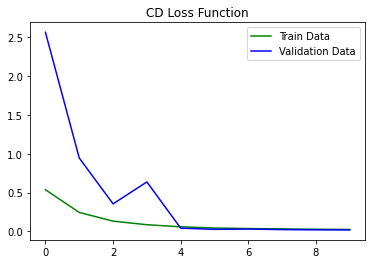

In [152]:
plt.plot(history.history['dense_78_loss'], color='green', label='Train Data')
plt.plot(history.history['val_dense_78_loss'], color='blue', label='Validation Data')
plt.title('CD Loss Function')
plt.legend()
plt.show()